In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

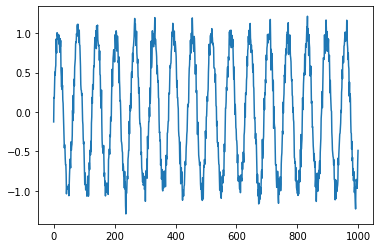

In [2]:
# Make the original data
N = 1000
series = np.sin(0.1*np.arange(N)) + np.random.randn(N)*0.1

# Plot it
plt.plot(series)
plt.show()

In [3]:
### Build the dataset
# Can we use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Need to reshape into N x T x D where D is 1
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990, 1)


In [4]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
### Define simple RNN
class SimpleRNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(SimpleRNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note : batch_first=True
    # applies the convention that the data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.RNN(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        nonlinearity='relu',
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K) # final dense layer of size M x K

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    # out is of size (N, T, M)
    # 2nd return value is hidden states at each hidden layer
    # which are not needed right now
    out, _ = self.rnn(X, h0)

    # Only interested in h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:, -1, :])
    return out


In [6]:
# Instantiate the model
model = SimpleRNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [7]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

Can't split up data randomly as real forcasting models need to predict the future, and therefore can't train on points within that future. In this case I will train on the first half and test on the second half (this is not necessary for sine waves as they are periodic, but I feel like it's good practice anyway). The most important detail is that all of the validation data occurs after the last point of training data. 

In [8]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [9]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [10]:
#Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):
  
  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it+1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {loss.item():.4f}')

  return train_losses, test_losses

In [11]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.1875, Test Loss: 0.1875
Epoch 10/200, Train Loss: 0.0699, Test Loss: 0.0699
Epoch 15/200, Train Loss: 0.0646, Test Loss: 0.0646
Epoch 20/200, Train Loss: 0.0335, Test Loss: 0.0335
Epoch 25/200, Train Loss: 0.0310, Test Loss: 0.0310
Epoch 30/200, Train Loss: 0.0287, Test Loss: 0.0287
Epoch 35/200, Train Loss: 0.0240, Test Loss: 0.0240
Epoch 40/200, Train Loss: 0.0238, Test Loss: 0.0238
Epoch 45/200, Train Loss: 0.0220, Test Loss: 0.0220
Epoch 50/200, Train Loss: 0.0217, Test Loss: 0.0217
Epoch 55/200, Train Loss: 0.0214, Test Loss: 0.0214
Epoch 60/200, Train Loss: 0.0212, Test Loss: 0.0212
Epoch 65/200, Train Loss: 0.0212, Test Loss: 0.0212
Epoch 70/200, Train Loss: 0.0211, Test Loss: 0.0211
Epoch 75/200, Train Loss: 0.0210, Test Loss: 0.0210
Epoch 80/200, Train Loss: 0.0210, Test Loss: 0.0210
Epoch 85/200, Train Loss: 0.0209, Test Loss: 0.0209
Epoch 90/200, Train Loss: 0.0208, Test Loss: 0.0208
Epoch 95/200, Train Loss: 0.0206, Test Loss: 0.0206
Epoch 100/200

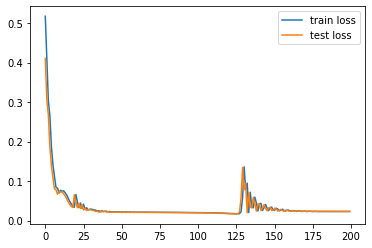

In [12]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [13]:
# "Wrong" forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# Index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
  # Want a shape of N x T x D where N and D are 1
  input_ = X_test[i].view(1, T, 1) 
  # Retreive N x K output where N and K are 1, so index by 0, 0
  p = model(input_)[0, 0].item() # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

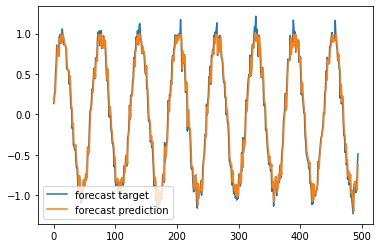

In [14]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

The issue with this approach is using the true input data to predict true values of the time series. Define a variable last_x to define the first input vector and take no new values from the actual dataset. 

In [15]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# Last train input
#last_x = torch.from_numpy(X[-N//2].astype(np.float32))
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.view(1, T, 1)
  p = model(input_)
  # [0, 0] # 1x1 array -> scalar

  # Update the predictions list
  validation_predictions.append(p[0, 0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

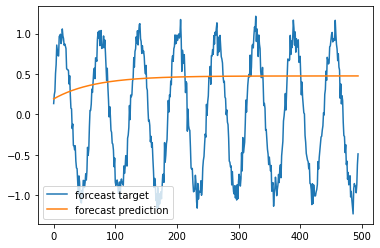

In [16]:
plt.plot(validation_target, label='forceast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

The above approach creates a sliding window of data, where after each iteration of the loop the first value of x is thrown away, and then the remaining values are concatenated with the new prediction (which keeps the shape of the inputs consistent). 

Unlike in the linear model, the RNN does not perform as well when using the default arguments. This is because an RNN has too much flexibility and too many parameters, so it is overparameterised. An AR model would be a better tool to use here, as it is more suited to the task at hand. 